In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#import and format data
feature_type = 'Ulz'
metadata_columns = ['cancer_present','sample_type','bam_name']
probabilities = pd.read_csv(feature_type+'_results/probabilities.txt', sep='\t')

n_iter = 1+probabilities.drop(columns = ['sample','status']+metadata_columns).head().columns.astype(int).max()
probabilities[np.arange(n_iter)] = probabilities[[str(m)for m in np.arange(n_iter)]]
probabilities = probabilities.drop(columns = [str(m)for m in np.arange(n_iter)])
probabilities = probabilities.sort_values(by='sample_type').reset_index(drop=True)

print(n_iter)

1000


In [3]:
probabilities.head()

,sample,bam_name,sample_type,cancer_present,status,0,1,2,3,4,...,990,991,992,993,994,995,996,997,998,999
0,Bile_Duct_Cancer_CGPLPA122,PGDX8174P_WGS.sorted_processed,Bile_Duct_Cancer,1,1,NaN,NaN,NaN,0.999617,NaN,...,NaN,NaN,0.853820,NaN,NaN,NaN,0.771406,0.996503,NaN,NaN
1,Bile_Duct_Cancer_CGPLPA140,PGDX8262P_WGS.sorted_processed,Bile_Duct_Cancer,1,1,0.793697,NaN,0.816577,NaN,0.690452,...,NaN,NaN,NaN,NaN,NaN,0.476215,0.620207,NaN,0.214502,NaN
2,Bile_Duct_Cancer_CGPLPA128,PGDX8256P_WGS.sorted_processed,Bile_Duct_Cancer,1,1,NaN,NaN,NaN,0.999624,NaN,...,NaN,0.116946,NaN,0.999438,NaN,NaN,NaN,NaN,0.101044,NaN
3,Bile_Duct_Cancer_CGPLPA131,PGDX8259P_WGS.sorted_processed,Bile_Duct_Cancer,1,1,NaN,NaN,0.296722,NaN,NaN,...,NaN,NaN,0.796663,NaN,NaN,0.829098,0.800887,NaN,0.948386,0.9978
4,Bile_Duct_Cancer_CGPLPA184,PGDX16601P_WGS.sorted_processed,Bile_Duct_Cancer,1,1,NaN,NaN,NaN,NaN,0.866969,...,NaN,NaN,NaN,NaN,0.999893,NaN,0.724093,0.999783,0.998386,NaN


In [4]:
#get AUC and accuracy for each bootstrap
AUCs = pd.DataFrame(columns = ['group','AUC'])
#accuracies = pd.DataFrame(columns = ['group','accuracy'])
#accuracy_per_sample = pd.DataFrame(index=probabilities.index)

for i in range(n_iter):
    if i%100==0:
        print(i)
    current = probabilities[~(probabilities[i].isnull())][['status','sample_type',i]].copy()
    #current['accuracy'] = np.where(np.round(current[i])==current['status'],1,0)
    #accuracy_per_sample[i] = current['accuracy']

    #overall accuracy and AUC
    group = 'overall'
    fpr,tpr,_ = roc_curve(current['status'],current[i])
    AUC = auc(fpr,tpr)
    AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)

    #accuracy = current['accuracy'].mean()
    #accuracies = accuracies.append({'group':group, 'accuracy':accuracy}, ignore_index = True)

    #separate out the healthy samples to be used in every AUC
    healthy_df = current[current['sample_type']=='Healthy']
    
    for group,df in current.groupby('sample_type'):
        if group == 'Healthy' or group == 'Duodenal_Cancer':
            continue
            
        #accuracy = df['accuracy'].mean()
        #accuracies = accuracies.append({'group':group, 'accuracy':accuracy}, ignore_index = True)
        
        df2 = df.append(healthy_df, ignore_index=True)
        fpr,tpr,_ = roc_curve(df2['status'],df2[i])
        AUC = auc(fpr,tpr)
        AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)
        
#     for group,df in current.groupby('Stage'):
#         if group == '0' or group == 'X':
#             continue
#         df2 = df.append(healthy_df, ignore_index=True)
#         fpr,tpr,_ = roc_curve(df2['status'],df2[i])
#         AUC = auc(fpr,tpr)
#         AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)
        
#     zero_tfx = current[(current['tumor_fraction']==0) & (current['sample_type']!='Healthy')]
#     low_tfx = current[(current['tumor_fraction']>0) & (current['tumor_fraction']<0.05) & (current['sample_type']!='Healthy')]
#     high_tfx = current[(current['tumor_fraction']>=0.05) & (current['sample_type']!='Healthy')]
    
#     for group,df in zip(['0_TFx','>0-0.05_TFx','>=0.05_TFx'],[zero_tfx,low_tfx,high_tfx]):
#         df2 = df.append(healthy_df, ignore_index=True)
#         fpr,tpr,_ = roc_curve(df2['status'],df2[i])
#         AUC = auc(fpr,tpr)
#         AUCs = AUCs.append({'group':group, 'AUC':AUC}, ignore_index = True)


0
100
200
300
400
500
600
700
800
900


In [5]:
#calculate confidence intervals
AUC_CI_df = AUCs.groupby('group').mean()
AUC_CI_df = AUC_CI_df.rename(columns = {'AUC':'mean'})

#get CI for each bootstrap
AUC_CI_df['lower'] = AUCs.groupby('group').quantile(.025)
AUC_CI_df['upper'] = AUCs.groupby('group').quantile(.975)
AUC_CI_df['metric']='AUC'

AUC_CI_df.to_csv(feature_type+'_results/CI_metrics.txt', sep='\t')
CI = AUC_CI_df.reset_index() #because I used this below

In [6]:
CI

,group,mean,lower,upper,metric
0,Bile_Duct_Cancer,0.831131,0.686003,0.951763,AUC
1,Breast_Cancer,0.820920,0.722080,0.909116,AUC
2,Colorectal_Cancer,0.920038,0.817376,0.990268,AUC
3,Gastric_cancer,0.807268,0.667052,0.940767,AUC
4,Lung_Cancer,0.932832,0.778846,1.000000,AUC
5,Ovarian_Cancer,0.924986,0.842304,0.981580,AUC
6,Pancreatic_Cancer,0.785473,0.656903,0.906981,AUC
7,overall,0.847394,0.796380,0.895026,AUC


Bile_Duct_Cancer 0.864
Bile_Duct_Cancer 0.8311309298883708
Breast_Cancer 0.861584840654608
Breast_Cancer 0.8209199461816465
Colorectal_Cancer 0.9403962101636519
Colorectal_Cancer 0.9200377554099877
Gastric_cancer 0.837037037037037
Gastric_cancer 0.8072681682044257
Lung_Cancer 0.9631782945736433
Lung_Cancer 0.932832015469929
Ovarian_Cancer 0.9571428571428572
Ovarian_Cancer 0.9249859058020474
Pancreatic_Cancer 0.8017783857729138
Pancreatic_Cancer 0.7854727539832533


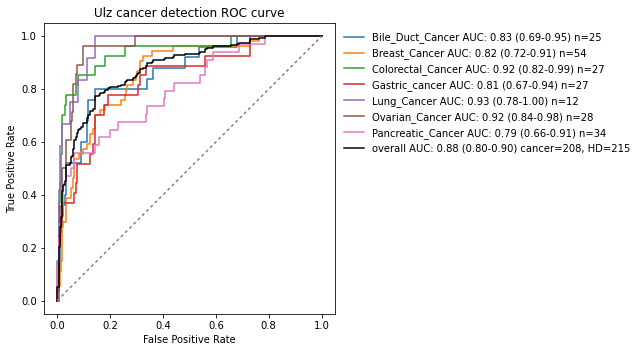

In [7]:
number_of_HD = len(probabilities[(probabilities['sample_type']=='Healthy')])
probabilities['median_probability'] = probabilities[np.arange(n_iter)].median(axis=1)

fig,ax = plt.subplots(figsize = (9.5,6))

for sample_type in probabilities['sample_type'].unique():
    if sample_type == 'Duodenal_Cancer' or sample_type == 'Healthy':#there is only one sample for Duodenal_Cancer, Healthy is included in all roc curves
        continue
    current = probabilities[(probabilities['sample_type']==sample_type) | (probabilities['sample_type']=='Healthy')]

    fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'].values)
    auc_val = auc(fpr,tpr)
    print(sample_type, auc_val)
    lower_AUC = CI[(CI['group']==sample_type) & (CI['metric']=='AUC')]['lower'].values[0]
    upper_AUC = CI[(CI['group']==sample_type) & (CI['metric']=='AUC')]['upper'].values[0]
    auc_val = CI[(CI['group']==sample_type) & (CI['metric']=='AUC')]['mean'].values[0]
    print(sample_type, auc_val)
    
    label = sample_type+' '+\
        'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
        ' n='+str(len(current)-number_of_HD)
    
    ax.plot(fpr,tpr, label=label)

    
#add overall AUC
fpr, tpr, _ = roc_curve(probabilities['status'].values,probabilities['median_probability'].values)
auc_val = auc(fpr,tpr)

lower_AUC = CI[(CI['group']=='overall') & (CI['metric']=='AUC')]['lower'].values[0]
upper_AUC = CI[(CI['group']=='overall') & (CI['metric']=='AUC')]['upper'].values[0]

label = 'overall AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+') '+\
    'cancer='+str(len(probabilities)-number_of_HD)+', HD='+str(number_of_HD)

ax.plot(fpr,tpr,color='black', label = label)

ax.legend(bbox_to_anchor = [1,1],loc = 'upper left', frameon = False)

ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

ax.set_title(feature_type+' cancer detection ROC curve')
ax.set_aspect('equal')
fig.subplots_adjust(right=.55)

plt.savefig(feature_type+'_results/'+feature_type+'_ROC_by_cancer_type.pdf')

In [8]:
# fig,ax = plt.subplots(figsize = (9,6))

# for stage in ['I','II', 'III','IV']:
#     current = probabilities[(probabilities['Stage']==stage) | (probabilities['sample_type']=='Healthy')]

#     fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'].values)
#     auc_val = auc(fpr,tpr)
    
#     lower_AUC = CI[(CI['group']==stage) & (CI['metric']=='AUC')]['lower'].values[0]
#     upper_AUC = CI[(CI['group']==stage) & (CI['metric']=='AUC')]['upper'].values[0]
    
#     label = stage+' '+\
#         'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
#         ' n='+str(len(current)-number_of_HD)

#     ax.plot(fpr,tpr, label=label)
    
    
# ax.legend(bbox_to_anchor = [1,1],loc = 'upper left', frameon = False)

# ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))

# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')

# ax.set_title('cancer detection ROC curve')
# ax.set_aspect('equal')
# fig.subplots_adjust(right=.55)

# plt.savefig(feature_type+'_results/'+feature_type+'_ROC_by_stage.pdf')

In [9]:
# #plot the ROC curves 
# fig,ax = plt.subplots(figsize = (9,6))

# HD_samples = probabilities[probabilities['sample'].str.contains('Healthy')]

# #plot zero tfx samples
# current_cancer = probabilities[(probabilities['tumor_fraction']==0) & (probabilities['status']==1)]
# current = current_cancer.append(HD_samples)
# print(len(current))
# fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'])
# auc_val = auc(fpr,tpr)

# group = '0_TFx'
# lower_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['lower'].values[0]
# upper_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['upper'].values[0]

# label = group+' '+\
#     'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
#     ' n='+str(len(current)-number_of_HD)

# ax.plot(fpr,tpr, label = label)

# #plot 0 to 0.05
# current_cancer = probabilities[(probabilities['tumor_fraction']>0) & (probabilities['tumor_fraction']<0.05) & (probabilities['status']==1)]
# current = current_cancer.append(HD_samples)
# print(len(current))
# fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'])
# auc_val = auc(fpr,tpr)

# group = '>0-0.05_TFx'
# lower_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['lower'].values[0]
# upper_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['upper'].values[0]

# label = group+' '+\
#     'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
#     ' n='+str(len(current)-number_of_HD)

# ax.plot(fpr,tpr, label = label)

# #plot 0 to 0.05
# current_cancer = probabilities[(probabilities['tumor_fraction']>=0.05) & (probabilities['status']==1)]
# current = current_cancer.append(HD_samples)
# print(len(current))
# fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'])
# auc_val = auc(fpr,tpr)

# group = '>=0.05_TFx'
# lower_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['lower'].values[0]
# upper_AUC = CI[(CI['group']==group) & (CI['metric']=='AUC')]['upper'].values[0]

# label = group+' '+\
#     'AUC: '+ format(auc_val,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'+\
#     ' n='+str(len(current)-number_of_HD)

# ax.plot(fpr,tpr, label = label)

# ax.legend(bbox_to_anchor = [1,1],loc = 'upper left', frameon = False)
# ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))
# ax.set_xlabel('False Positive Rate')
# ax.set_ylabel('True Positive Rate')
# ax.set_title('ROC by tumor fraction')
# ax.set_aspect('equal')
# fig.subplots_adjust(right=.55)

# plt.savefig(feature_type+'_results/'+feature_type+'_ROC_curves_by_tfx.pdf')